In [4]:
# 0. Import all libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# 1. Import data
file_path = './data/SMCI.csv'
data = pd.read_csv(file_path)

# Data Cleaning
columns_to_convert = ['Close/Last', 'Open', 'High', 'Low']
for column in columns_to_convert:
    data[column] = data[column].str.replace('$', '').str.replace(',', '').astype(float)

data['Date'] = pd.to_datetime(data['Date'])
train_set = data[(data['Date'] >= '2014-06-24') & (data['Date'] < '2023-06-24')].copy()

# 2. Setup Variables
time_steps = 90

# 3. Data pre-processing
scaler = MinMaxScaler(feature_range=(0, 1))

# Normalize the 'Close/Last' column for training set
train_data = scaler.fit_transform(train_set['Close/Last'].values.reshape(-1, 1))

# Initialize lists to store training data
x_train, y_train = [], []
for i in range(time_steps, len(train_data)):
    x_train.append(train_data[i-time_steps:i, 0])
    y_train.append(train_data[i, 0])  # Target is the next day's Close/Last

# Convert lists to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# 4. Build Model - function
def build_model():
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# 5. Training - Function
def train_model(model, x_train, y_train):
    model.fit(x_train, y_train, epochs=25, batch_size=32)

# 6. Make Prediction - Function
def make_one_step_prediction(model, data, scaler):
    last_data = data[-time_steps:]
    last_data = np.reshape(last_data, (1, last_data.shape[0], 1))
    predicted_price = model.predict(last_data)
    predicted_price = scaler.inverse_transform(predicted_price)
    return predicted_price

# Execute steps 4, 5, 6
model = build_model()
train_model(model, x_train, y_train)

# Predict next day's Close/Last price
predicted_price = make_one_step_prediction(model, train_data, scaler)
print("Predicted Close Price for the next day:", predicted_price)


/Users/beilinye/Desktop/Spring_2024/SYDE_660a/6_Code/stock-prediction/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0019
Epoch 2/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 1.9146e-04
Epoch 3/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 1.6184e-04
Epoch 4/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 1.7811e-04
Epoch 5/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 1.4223e-04
Epoch 6/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 1.6647e-04
Epoch 7/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 1.4291e-04
Epoch 8/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 1.1517e-04
Epoch 9/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 1.0966e-04
Epoch 10/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 1.2523e-04
Epoch 11/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 1.1507e-04
Epoch 12/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 1.1337e-04
Epoch 13/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 1.0633e-04
Epoch 14/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 9.4007e-05
Epoch 15/25
68/68 ━

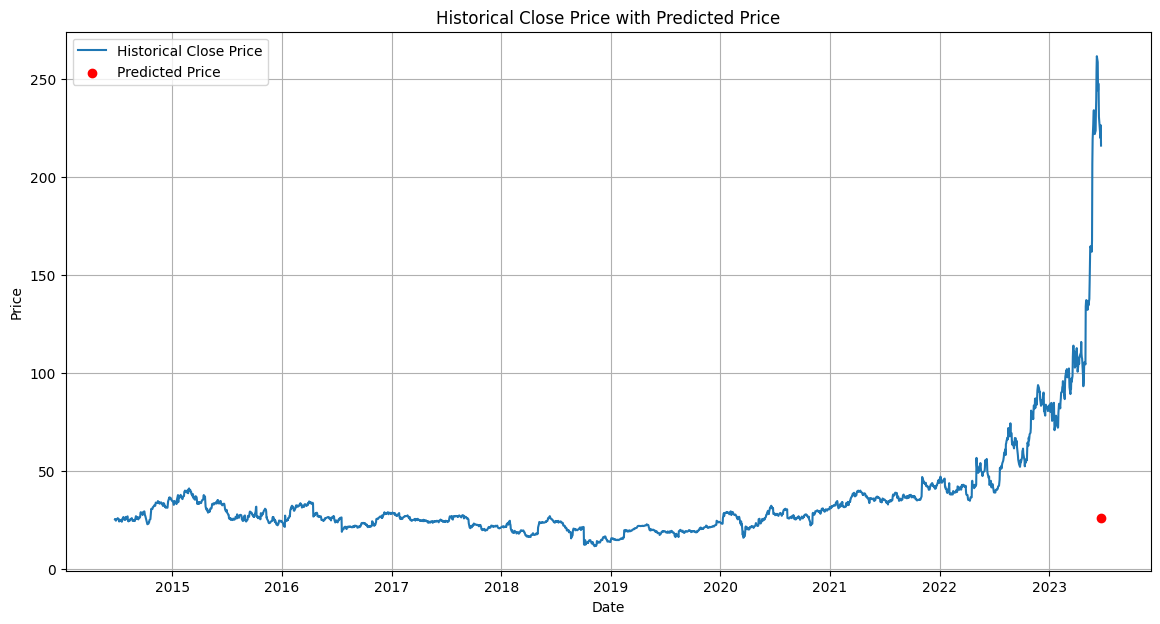

In [5]:
# Import libraries (if not already imported)
import matplotlib.pyplot as plt

# Find the last date in the training set
last_date = train_set['Date'].max()

# Plot historical Close/Last prices
plt.figure(figsize=(14, 7))
plt.plot(train_set['Date'], train_set['Close/Last'], label='Historical Close Price')

# Plot predicted price as a red point
predicted_date = last_date + pd.Timedelta(days=1)
plt.scatter(predicted_date, predicted_price, color='red', label='Predicted Price')

plt.title('Historical Close Price with Predicted Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()